<a href="https://colab.research.google.com/github/BatoolMM/fastai/blob/master/Chapter_4_Under_the_Hood_Training_a_Digit_Classifier_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chapter 4. Under the Hood: Training a Digit Classifier**

In [1]:
!pip install -Uqq fastbook
!pip install fastcore
!pip install fastai
!pip install utils

     |████████████████████████████████| 727kB 4.3MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 1.0MB 12.0MB/s 
     |████████████████████████████████| 194kB 24.2MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 40kB 6.0MB/s 
     |████████████████████████████████| 92kB 8.5MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 2.6MB 17.7MB/s 


In [2]:
from utils import *
from fastai.vision.all import *
from fastai.vision.widgets import ImageClassifierCleaner

In [3]:
?download_images

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/train')]

In [5]:
(path/'train'/'7').ls()

(#6265) [Path('/root/.fastai/data/mnist_sample/train/7/31219.png'),Path('/root/.fastai/data/mnist_sample/train/7/23173.png'),Path('/root/.fastai/data/mnist_sample/train/7/6623.png'),Path('/root/.fastai/data/mnist_sample/train/7/2297.png'),Path('/root/.fastai/data/mnist_sample/train/7/5897.png'),Path('/root/.fastai/data/mnist_sample/train/7/51819.png'),Path('/root/.fastai/data/mnist_sample/train/7/30759.png'),Path('/root/.fastai/data/mnist_sample/train/7/13691.png'),Path('/root/.fastai/data/mnist_sample/train/7/6587.png'),Path('/root/.fastai/data/mnist_sample/train/7/10474.png')...]

In [6]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [7]:
tensor_threes = [tensor(Image.open(i)) for i in threes]
tensor_sevens = [tensor(Image.open(i)) for i in sevens]
tensor_threes[1][4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

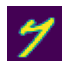

In [8]:
show_image(tensor_sevens[1])

In [9]:
stacked_threes = torch.stack(tensor_threes).float()/255
stacked_sevens = torch.stack(tensor_sevens).float()/255

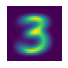

In [10]:
show_image(stacked_threes.mean(0))

In [11]:
abs_three_tomeanthree = (stacked_threes.mean(0) - stacked_threes[1]).abs().mean()
rmse_three_tomeanthree = ((stacked_threes.mean(0) - stacked_threes[1])**2).mean().sqrt()
abs_three_tomeanthree, rmse_three_tomeanthree

(tensor(0.1114), tensor(0.2021))

In [12]:
abs_three_tomeanseven = (stacked_sevens.mean(0) - stacked_threes[1]).abs().mean()
rmse_three_tomeanseven = ((stacked_sevens.mean(0) - stacked_threes[1])**2).mean().sqrt()
abs_three_tomeanseven, rmse_three_tomeanseven

(tensor(0.1586), tensor(0.3021))

In [13]:
#in pytorch

abs_three_tomeanseven = F.l1_loss(stacked_sevens.mean(0), stacked_threes[1])
rmse_three_tomeanseven = F.mse_loss(stacked_sevens.mean(0) , stacked_threes[1]).sqrt()
abs_three_tomeanseven, rmse_three_tomeanseven

(tensor(0.1586), tensor(0.3021))

## **Validation set**

In [14]:
(path/'valid').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/valid/7'),Path('/root/.fastai/data/mnist_sample/valid/3')]

In [15]:
valid_three = torch.stack([tensor(Image.open(i)) for i in (path/'valid'/'3').ls()])
valid_three = valid_three.float()/255
valid_seven = torch.stack([tensor(Image.open(i)) for i in (path/'valid'/'7').ls()])
valid_seven = valid_seven.float()/225
valid_three.shape,valid_seven.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [16]:
mean_seven = stacked_sevens.mean(0)
mean_three = stacked_threes.mean(0)
#without broadcasting
(valid_seven - mean_three).abs().mean(), (valid_seven - mean_three).abs().mean().shape

#with broadcasting
(valid_seven - mean_three).abs().mean((-1,-2)), (valid_seven - mean_three).abs().mean((-1,-2)).shape

(tensor([0.1574, 0.1652, 0.1653,  ..., 0.1569, 0.1814, 0.1599]),
 torch.Size([1028]))

In [17]:
def mnist_l1_loss(a, b):
  return (a - b).abs().mean((-1, -2))

mnist_l1_loss(valid_seven, mean_three,), mnist_l1_loss(valid_seven, mean_three).shape

(tensor([0.1574, 0.1652, 0.1653,  ..., 0.1569, 0.1814, 0.1599]),
 torch.Size([1028]))

In [18]:
def is_three(x):
  mean_seven = stacked_sevens.mean(0)
  mean_three = stacked_threes.mean(0)
  return mnist_l1_loss(x, mean_three) < mnist_l1_loss(x, mean_seven)

is_three(valid_three), is_three(valid_three).float()

(tensor([False,  True,  True,  ..., False,  True,  True]),
 tensor([0., 1., 1.,  ..., 0., 1., 1.]))

In [19]:
accuracy_3 = is_three(valid_three).float().mean()
accuracy_7 = (1 - is_three(valid_seven).float()).mean()
accuracy_3, accuracy_7

(tensor(0.9168), tensor(0.9864))

## **Gradient descent**

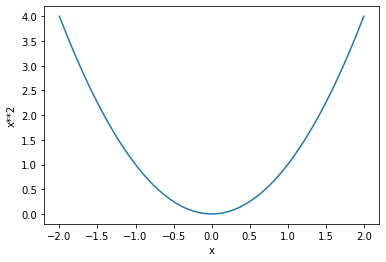

In [20]:
def f(x):
  return x**2

def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

plot_function(f,'x', 'x**2')

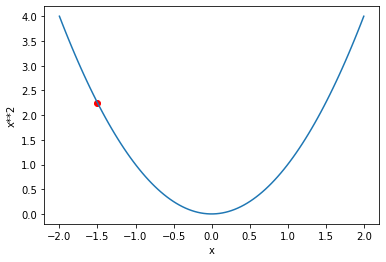

In [21]:
plot_function(f,'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red')

In [22]:
def f(x):
  return x**2

In [23]:
der_x_3 = tensor(3.).requires_grad_()
der_x_3

tensor(3., requires_grad=True)

In [24]:
der_f = f(der_x_3)
der_f

tensor(9., grad_fn=<PowBackward0>)

In [25]:
der_f.backward()
der_x_3.grad

tensor(6.)

## **Roller coaster**

In [40]:
time = torch.arange(20.)
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

In [27]:
#original speed
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
speed

tensor([6.7770e+01, 5.1969e+01, 4.3697e+01, 3.5544e+01, 2.6175e+01, 1.4164e+01,
        8.5500e+00, 1.2710e+01, 7.1383e+00, 2.7341e-02, 4.5734e-01, 7.7645e+00,
        2.6817e+00, 1.0055e+01, 1.9429e+01, 2.1024e+01, 3.5434e+01, 3.4602e+01,
        5.7773e+01, 7.0080e+01])

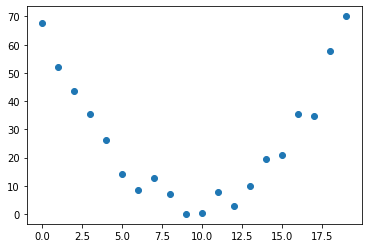

In [28]:
plt.scatter(time, speed)

In [46]:
#the equation
def f(t, params):
  a,b,c = params
  return a*(t**2) + (b*t) + c

In [47]:
#initi the weights
params = torch.randn(3).requires_grad_()
params

tensor([-0.2054,  0.0130, -0.5498], requires_grad=True)

In [48]:
#define loss function
def mse(pred, target):
  return ((target - pred)**2).mean()

In [49]:
#check the weights with function and lose function
pred = f(time, params)
pred

tensor([ -0.5498,  -0.7422,  -1.3455,  -2.3596,  -3.7846,  -5.6204,  -7.8671,
        -10.5246, -13.5930, -17.0721, -20.9622, -25.2631, -29.9748, -35.0974,
        -40.6308, -46.5750, -52.9301, -59.6960, -66.8728, -74.4605],
       grad_fn=<AddBackward0>)

In [56]:
loss = mse(pred, speed)
loss 

tensor(3984.6392, grad_fn=<MeanBackward0>)

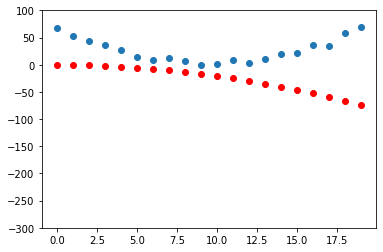

In [57]:
def show_pred(pred, plot=None):
  if plot is None:
    plot = plt.subplots()[1]
    plot.scatter(time, speed)
    plot.scatter(time, to_np(pred), color ='red')
    plot.set_ylim(-300, 100)

show_pred(pred)

In [58]:
loss.backward()
params.grad

tensor([-19388.0195,  -1247.4126,   -104.2968])